In [4]:
import math
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [5]:
batch_size = 128
lr = 3e-4
weight_decay = 1e-4
betas = (0.9, 0.95)
num_epochs = 60
warmup_epochs = 8
latent_dim = 2
label_embed_dim = 16
beta_values = [1.0, 4.0]
grad_clip = 1.0


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(), # MNIST in [0,1]
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


In [7]:
print('Train size:', len(train_ds), 'Test size:', len(test_ds))

Train size: 60000 Test size: 10000


# Part 1: CVAE + β-VAE Implementation & Training

In [9]:
def weights_init_small(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.normal_(m.weight, mean=0.0, std=1e-2)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class CVAE(nn.Module):
    def __init__(self, latent_dim=2, label_embed_dim=16):
        super().__init__()
        self.label_emb = nn.Embedding(10, label_embed_dim)
        # Encoder: convs
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1), # 28->14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 14->7
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # 7->7
            nn.ReLU(),
        )
        # flatten to 128*7*7 then linear to 256 after concat label embedding
        self.fc1 = nn.Linear(128*7*7 + label_embed_dim, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)  # produce log sigma^2

        # Decoder
        self.dec_fc1 = nn.Linear(latent_dim + label_embed_dim, 256)
        self.dec_fc2 = nn.Linear(256, 128*7*7)
        # Deconv
        self.dec_deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), #7->14
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), #14->28
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1), # logits
        )

        # initialize
        self.apply(weights_init_small)
        # zero-init final decoder conv for stable start (weights and bias)
        nn.init.zeros_(self.dec_deconv[-1].weight)
        nn.init.zeros_(self.dec_deconv[-1].bias)

    def encode(self, x, y):
        """
        x: (B,1,28,28), y: (B,)
        returns mu (B,latent), logvar (B,latent)
        """
        h = self.enc_conv(x)  # (B,128,7,7)
        h = h.view(h.size(0), -1)  # (B, 128*7*7)
        y_emb = self.label_emb(y)  # (B,label_embed_dim)
        h = torch.cat([h, y_emb], dim=1)  # (B, 128*7*7 + label_embed_dim)
        h = F.relu(self.fc1(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        # clamp logvar as assignment suggests
        logvar = torch.clamp(logvar, min=-8.0, max=8.0)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z, y):
        y_emb = self.label_emb(y)
        h = torch.cat([z, y_emb], dim=1)
        h = F.relu(self.dec_fc1(h))
        h = F.relu(self.dec_fc2(h))
        h = h.view(-1, 128, 7, 7)
        logits = self.dec_deconv(h)  # logits for BCEWithLogits
        return logits

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        logits = self.decode(z, y)
        return logits, mu, logvar, z


In [10]:
# Loss function per assignment (BCE with logits * 784 + beta * KL term)
bce_loss = nn.BCEWithLogitsLoss(reduction='none')  

def loss_function(logits, x, mu, logvar, beta):
    # logits: (B,1,28,28), x: (B,1,28,28)
    rec_map = bce_loss(logits, x)  # (B,1,28,28)
    recon = rec_map.sum(dim=[1,2,3])  # sum per image
    kl_element = 0.5 * (mu.pow(2) + logvar.exp() - 1.0 - logvar)
    kl = kl_element.sum(dim=1)  # per image
    loss = recon + beta * kl
    return loss.mean(), recon.mean(), kl.mean()


In [11]:
def plot_curves(hist, title=None):
    # hist is dict with keys 'train_loss', 'val_loss', 'train_recon', 'val_recon', 'train_kl','val_kl'
    epochs = np.arange(1, len(hist['train_loss'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(epochs, hist['train_loss'], label='train')
    plt.plot(epochs, hist['val_loss'], label='val')
    plt.title('Total Loss' + (f' - {title}' if title else ''))
    plt.legend()
    plt.subplot(1,3,2)
    plt.plot(epochs, hist['train_recon'], label='train')
    plt.plot(epochs, hist['val_recon'], label='val')
    plt.title('Reconstruction (BCE sum)')
    plt.legend()
    plt.subplot(1,3,3)
    plt.plot(epochs, hist['train_kl'], label='train')
    plt.plot(epochs, hist['val_kl'], label='val')
    plt.title('KL')
    plt.legend()
    plt.tight_layout()
    plt.show()

def show_image_grid(img_tensors, nrow=8, title=None):
    grid = utils.make_grid(img_tensors, nrow=nrow, padding=2)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.cpu().permute(1,2,0).squeeze(), cmap='gray')
    if title: plt.title(title)
    plt.axis('off')
    plt.show()


In [12]:
# Train/val loop (single run), includes linear warmup for beta up to target_beta
def run_experiment(target_beta, run_name="run"):
    model = CVAE(latent_dim=latent_dim, label_embed_dim=label_embed_dim).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
    scheduler = None

    hist = {'train_loss':[], 'val_loss':[], 'train_recon':[], 'val_recon':[], 'train_kl':[], 'val_kl':[]}

    for epoch in range(1, num_epochs+1):
        model.train()
        train_losses = []
        train_recons = []
        train_kls = []
        # linear warmup for beta
        beta_eff = min(target_beta, target_beta * epoch / max(1, warmup_epochs))

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} (β={beta_eff:.3f})", leave=False)
        for x, y in pbar:
            x = x.to(device)
            y = y.to(device)
            logits, mu, logvar, _ = model(x, y)
            loss, recon, kl = loss_function(logits, x, mu, logvar, beta_eff)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            opt.step()
            train_losses.append(loss.item())
            train_recons.append(recon.item())
            train_kls.append(kl.item())
            pbar.set_postfix({'loss': np.mean(train_losses[-20:])})

        # validation
        model.eval()
        val_losses = []
        val_recons = []
        val_kls = []
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)
                logits, mu, logvar, _ = model(x, y)
                loss, recon, kl = loss_function(logits, x, mu, logvar, target_beta)
                val_losses.append(loss.item())
                val_recons.append(recon.item())
                val_kls.append(kl.item())

        hist['train_loss'].append(np.mean(train_losses))
        hist['val_loss'].append(np.mean(val_losses))
        hist['train_recon'].append(np.mean(train_recons))
        hist['val_recon'].append(np.mean(val_recons))
        hist['train_kl'].append(np.mean(train_kls))
        hist['val_kl'].append(np.mean(val_kls))

        # simple logging
        print(f"Epoch {epoch:02d} β_eff {beta_eff:.3f} | train loss {hist['train_loss'][-1]:.2f} val loss {hist['val_loss'][-1]:.2f}")

    return model, hist



=== Running experiment for beta = 1.0 ===


Epoch 01 β_eff 0.125 | train loss 198.00 val loss 157.13


Epoch 02 β_eff 0.250 | train loss 146.24 val loss 145.34


Epoch 03 β_eff 0.375 | train loss 139.11 val loss 140.34


Epoch 04 β_eff 0.500 | train loss 136.21 val loss 137.35


Epoch 05 β_eff 0.625 | train loss 135.01 val loss 135.91


Epoch 06 β_eff 0.750 | train loss 134.55 val loss 135.30


Epoch 07 β_eff 0.875 | train loss 134.36 val loss 134.28


Epoch 08 β_eff 1.000 | train loss 134.25 val loss 134.31


Epoch 09 β_eff 1.000 | train loss 133.72 val loss 133.57


Epoch 10 β_eff 1.000 | train loss 133.24 val loss 133.26


Epoch 11 β_eff 1.000 | train loss 132.81 val loss 132.76


Epoch 12 β_eff 1.000 | train loss 132.38 val loss 132.59


Epoch 13 β_eff 1.000 | train loss 132.04 val loss 132.28


Epoch 14 β_eff 1.000 | train loss 131.70 val loss 132.13


Epoch 15 β_eff 1.000 | train loss 131.43 val loss 131.89


Epoch 16 β_eff 1.000 | train loss 131.20 val loss 131.50


Epoch 17 β_eff 1.000 | train loss 130.99 val loss 131.46


Epoch 18 β_eff 1.000 | train loss 130.77 val loss 131.49


Epoch 19 β_eff 1.000 | train loss 130.66 val loss 131.20


Epoch 20 β_eff 1.000 | train loss 130.48 val loss 131.17


Epoch 21 β_eff 1.000 | train loss 130.34 val loss 131.17


Epoch 22 β_eff 1.000 | train loss 130.21 val loss 130.74


Epoch 23 β_eff 1.000 | train loss 130.03 val loss 130.60


Epoch 24 β_eff 1.000 | train loss 129.92 val loss 130.52


Epoch 25 β_eff 1.000 | train loss 129.83 val loss 130.33


Epoch 26 β_eff 1.000 | train loss 129.72 val loss 130.78


Epoch 27 β_eff 1.000 | train loss 129.61 val loss 130.25


Epoch 28 β_eff 1.000 | train loss 129.47 val loss 130.11


Epoch 29 β_eff 1.000 | train loss 129.41 val loss 130.16


Epoch 30 β_eff 1.000 | train loss 129.32 val loss 129.94


Epoch 31 β_eff 1.000 | train loss 129.22 val loss 129.91


Epoch 32 β_eff 1.000 | train loss 129.16 val loss 130.10


Epoch 33 β_eff 1.000 | train loss 129.08 val loss 129.81


Epoch 34 β_eff 1.000 | train loss 128.96 val loss 129.92


Epoch 35 β_eff 1.000 | train loss 128.88 val loss 129.86


Epoch 36 β_eff 1.000 | train loss 128.84 val loss 129.61


Epoch 37 β_eff 1.000 | train loss 128.73 val loss 129.73


Epoch 38 β_eff 1.000 | train loss 128.63 val loss 129.49


Epoch 39 β_eff 1.000 | train loss 128.59 val loss 129.53


Epoch 40 β_eff 1.000 | train loss 128.47 val loss 129.81


Epoch 41 β_eff 1.000 | train loss 128.41 val loss 129.49


Epoch 42 β_eff 1.000 | train loss 128.32 val loss 129.48


Epoch 43 β_eff 1.000 | train loss 128.26 val loss 129.50


Epoch 44 β_eff 1.000 | train loss 128.18 val loss 129.38


Epoch 45 β_eff 1.000 | train loss 128.12 val loss 129.32


Epoch 46 β_eff 1.000 | train loss 128.03 val loss 129.33


Epoch 47 β_eff 1.000 | train loss 128.00 val loss 129.33


Epoch 48 β_eff 1.000 | train loss 127.88 val loss 129.36


Epoch 49 β_eff 1.000 | train loss 127.79 val loss 129.21


Epoch 50 β_eff 1.000 | train loss 127.75 val loss 129.26


Epoch 51 β_eff 1.000 | train loss 127.68 val loss 129.02


Epoch 52 β_eff 1.000 | train loss 127.60 val loss 129.36


Epoch 53 β_eff 1.000 | train loss 127.49 val loss 129.28


Epoch 54 β_eff 1.000 | train loss 127.47 val loss 129.24


Epoch 55 β_eff 1.000 | train loss 127.37 val loss 128.95


Epoch 56 β_eff 1.000 | train loss 127.33 val loss 129.20


Epoch 57 β_eff 1.000 | train loss 127.25 val loss 128.89


Epoch 58 β_eff 1.000 | train loss 127.15 val loss 129.21


Epoch 59 β_eff 1.000 | train loss 127.10 val loss 128.88


Epoch 60 β_eff 1.000 | train loss 127.00 val loss 128.99


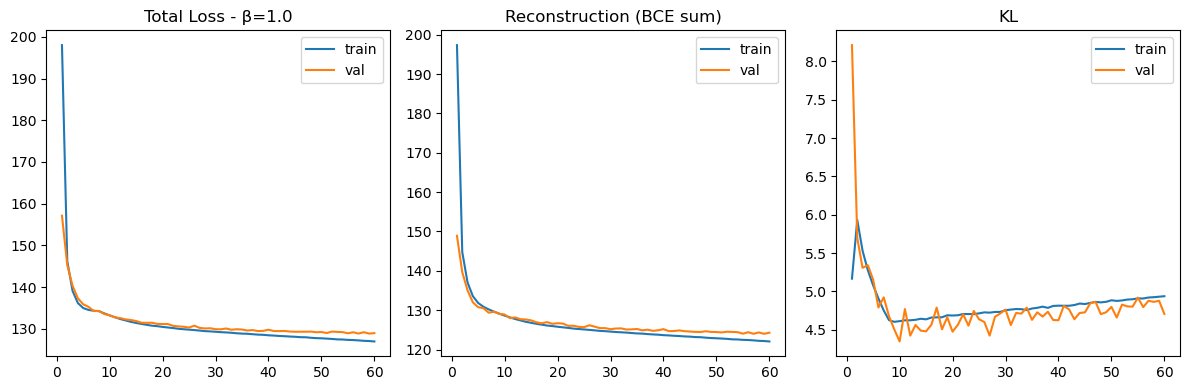


=== Running experiment for beta = 4.0 ===


Epoch 01 β_eff 0.500 | train loss 196.32 val loss 167.42


Epoch 02 β_eff 1.000 | train loss 147.98 val loss 155.41


Epoch 03 β_eff 1.500 | train loss 142.76 val loss 150.51


Epoch 04 β_eff 2.000 | train loss 141.51 val loss 147.30


Epoch 05 β_eff 2.500 | train loss 141.64 val loss 145.99


Epoch 06 β_eff 3.000 | train loss 142.33 val loss 145.13


Epoch 07 β_eff 3.500 | train loss 143.21 val loss 144.74


Epoch 08 β_eff 4.000 | train loss 144.20 val loss 143.91


Epoch 09 β_eff 4.000 | train loss 143.73 val loss 143.50


Epoch 10 β_eff 4.000 | train loss 143.39 val loss 143.17


Epoch 11 β_eff 4.000 | train loss 143.08 val loss 142.84


Epoch 12 β_eff 4.000 | train loss 142.78 val loss 142.79


Epoch 13 β_eff 4.000 | train loss 142.58 val loss 142.33


Epoch 14 β_eff 4.000 | train loss 142.33 val loss 142.30


Epoch 15 β_eff 4.000 | train loss 142.20 val loss 142.08


Epoch 16 β_eff 4.000 | train loss 141.99 val loss 142.15


Epoch 17 β_eff 4.000 | train loss 141.89 val loss 141.95


Epoch 18 β_eff 4.000 | train loss 141.80 val loss 142.04


Epoch 19 β_eff 4.000 | train loss 141.64 val loss 141.79


Epoch 20 β_eff 4.000 | train loss 141.51 val loss 141.33


Epoch 21 β_eff 4.000 | train loss 141.41 val loss 141.78


Epoch 22 β_eff 4.000 | train loss 141.27 val loss 141.39


Epoch 23 β_eff 4.000 | train loss 141.24 val loss 141.68


Epoch 24 β_eff 4.000 | train loss 141.15 val loss 141.15


Epoch 25 β_eff 4.000 | train loss 141.05 val loss 141.23


Epoch 26 β_eff 4.000 | train loss 141.02 val loss 141.45


Epoch 27 β_eff 4.000 | train loss 140.93 val loss 141.48


Epoch 28 β_eff 4.000 | train loss 140.89 val loss 141.03


Epoch 29 β_eff 4.000 | train loss 140.77 val loss 141.22


Epoch 30 β_eff 4.000 | train loss 140.76 val loss 141.00


Epoch 31 β_eff 4.000 | train loss 140.62 val loss 141.18


Epoch 32 β_eff 4.000 | train loss 140.63 val loss 140.93


Epoch 33 β_eff 4.000 | train loss 140.58 val loss 140.73


Epoch 34 β_eff 4.000 | train loss 140.51 val loss 140.73


Epoch 35 β_eff 4.000 | train loss 140.44 val loss 141.02


Epoch 36 β_eff 4.000 | train loss 140.38 val loss 141.00


Epoch 37 β_eff 4.000 | train loss 140.34 val loss 140.87


Epoch 38 β_eff 4.000 | train loss 140.30 val loss 140.83


Epoch 39 β_eff 4.000 | train loss 140.24 val loss 140.62


Epoch 40 β_eff 4.000 | train loss 140.14 val loss 140.69


Epoch 41 β_eff 4.000 | train loss 140.13 val loss 140.73


Epoch 42 β_eff 4.000 | train loss 140.13 val loss 140.68


Epoch 43 β_eff 4.000 | train loss 140.03 val loss 141.27


Epoch 44 β_eff 4.000 | train loss 140.01 val loss 140.64


Epoch 45 β_eff 4.000 | train loss 139.94 val loss 140.54


Epoch 46 β_eff 4.000 | train loss 139.92 val loss 140.52


Epoch 47 β_eff 4.000 | train loss 139.86 val loss 140.28


Epoch 48 β_eff 4.000 | train loss 139.86 val loss 140.57


Epoch 49 β_eff 4.000 | train loss 139.81 val loss 140.41


Epoch 50 β_eff 4.000 | train loss 139.77 val loss 140.26


Epoch 51 β_eff 4.000 | train loss 139.71 val loss 140.50


Epoch 52 β_eff 4.000 | train loss 139.68 val loss 140.36


Epoch 53 β_eff 4.000 | train loss 139.64 val loss 140.56


Epoch 54 β_eff 4.000 | train loss 139.55 val loss 140.24


Epoch 55 β_eff 4.000 | train loss 139.58 val loss 140.26


Epoch 56 β_eff 4.000 | train loss 139.46 val loss 140.17


Epoch 57 β_eff 4.000 | train loss 139.47 val loss 140.04


Epoch 58 β_eff 4.000 | train loss 139.44 val loss 139.98


Epoch 59 β_eff 4.000 | train loss 139.39 val loss 140.09


Epoch 60 β_eff 4.000 | train loss 139.39 val loss 139.91


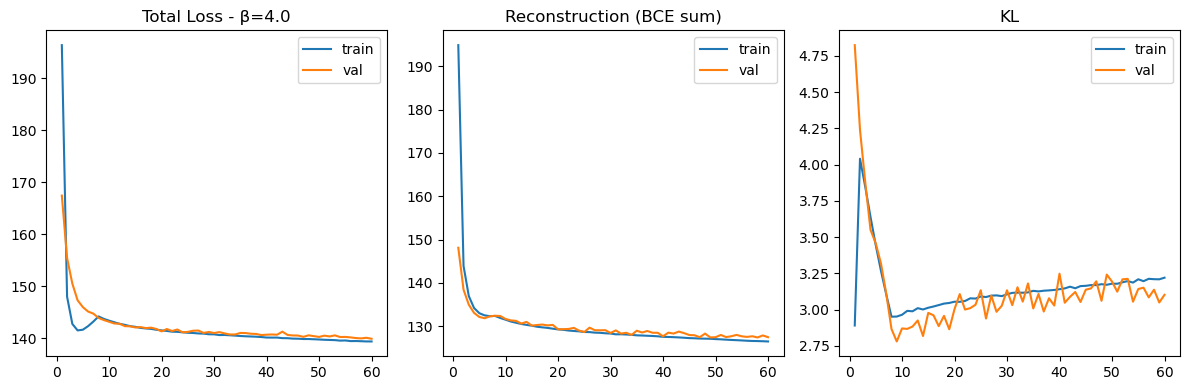

In [13]:
# Run experiments for beta=1 and beta=4 (this will take time)
results = {}
for beta in beta_values:
    print(f"\n=== Running experiment for beta = {beta} ===")
    model, hist = run_experiment(target_beta=beta, run_name=f"beta_{beta}")
    results[beta] = {'model': model, 'hist': hist}
    # Save model
    torch.save(model.state_dict(), f"cvae_beta_{int(beta)}.pt")
    # Plot curves
    plot_curves(hist, title=f"β={beta}")


# Part 2: Reconstructions & Conditional Generation

In [14]:
# Function to show originals and reconstructions side by side
def reconstruct_side_by_side_plots(model, dataset, beta, n=8):
    model.eval()
    imgs, labels = [], []
    cnt = 0
    for x, y in DataLoader(dataset, batch_size=1, shuffle=False):
        imgs.append(x)
        labels.append(y)
        cnt += 1
        if cnt >= n*n:
            break
    originals = torch.cat(imgs, dim=0).to(device)
    labels = torch.cat(labels, dim=0).to(device)

    with torch.no_grad():
        logits, _, _, _ = model(originals, labels)
        recon = torch.sigmoid(logits)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Originals
    grid_orig = utils.make_grid(originals.cpu(), nrow=n, padding=2)
    axes[0].imshow(grid_orig.permute(1,2,0).squeeze(), cmap="gray")
    axes[0].set_title(f"Original Images (β={beta})")
    axes[0].axis("off")
    
    # Reconstructions
    grid_recon = utils.make_grid(recon.cpu(), nrow=n, padding=2)
    axes[1].imshow(grid_recon.permute(1,2,0).squeeze(), cmap="gray")
    axes[1].set_title(f"Reconstructed Images (β={beta})")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


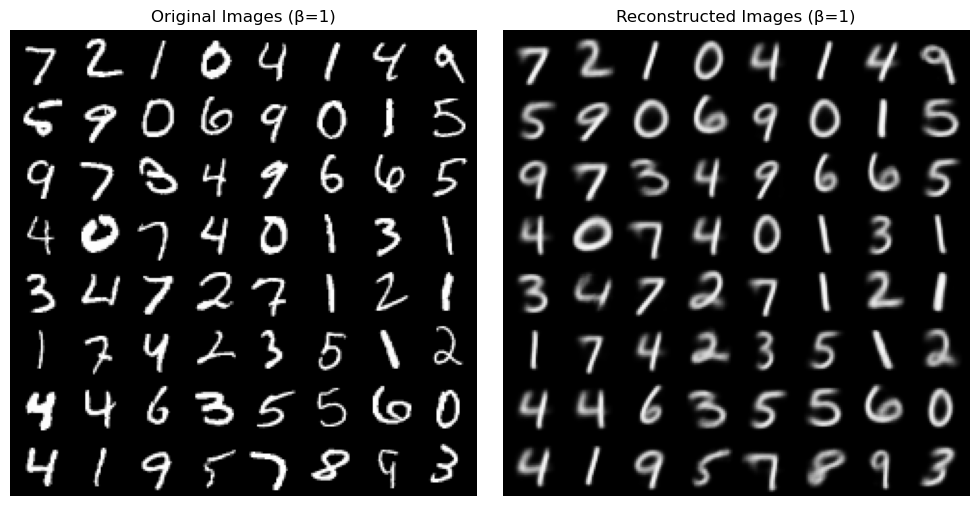

In [15]:
# Reconstructions for β = 1
reconstruct_side_by_side_plots(results[1.0]['model'], test_ds, beta=1, n=8)

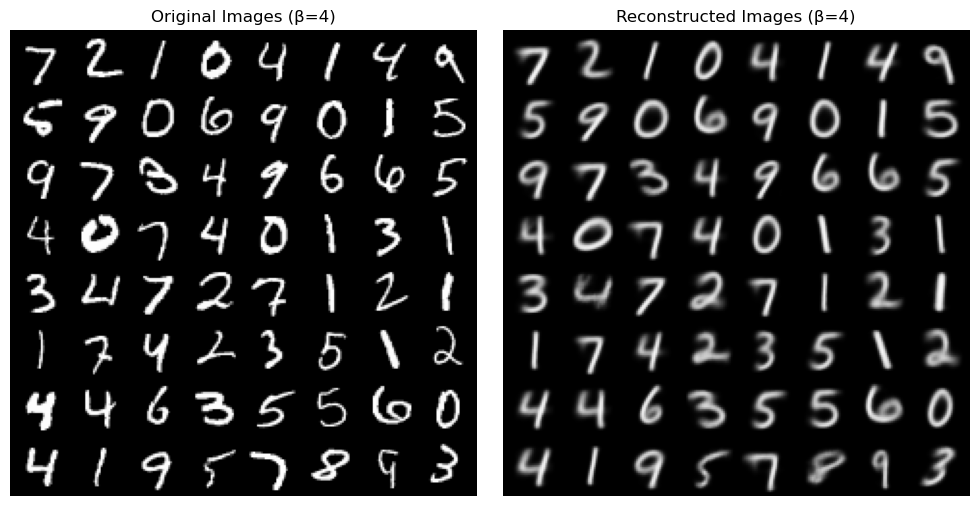

In [16]:
# Reconstructions for β = 4
reconstruct_side_by_side_plots(results[4.0]['model'], test_ds, beta=4, n=8)

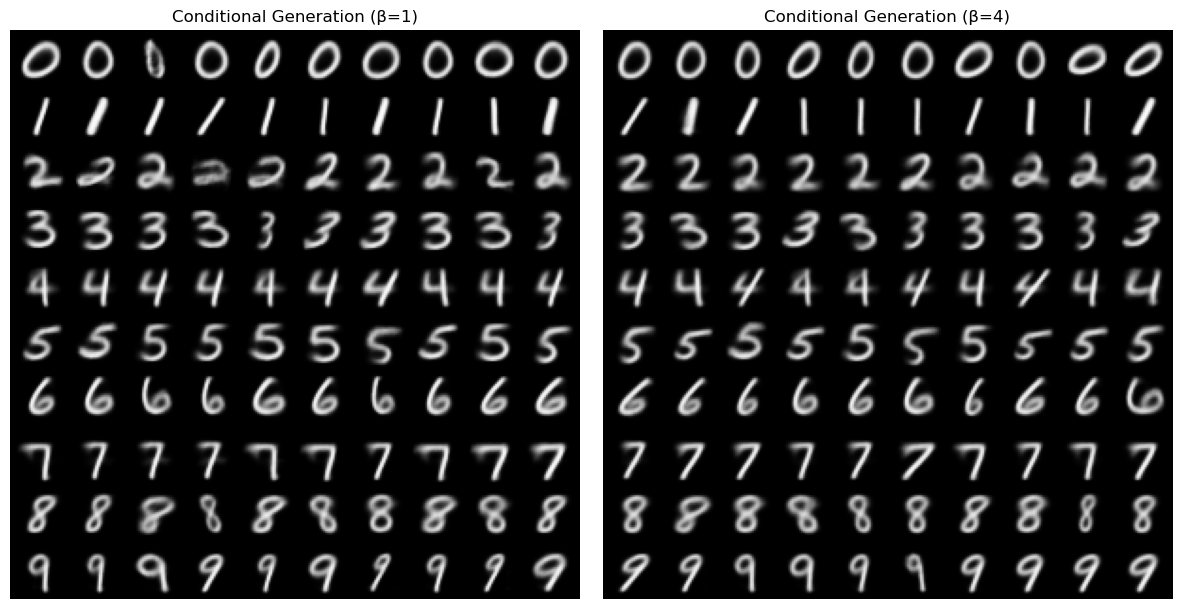

In [17]:
# Function: Conditional generation side-by-side for β=1 and β=4
def conditional_generation_compare(model1, model2, rows=10, cols=10):
    # β=1 generations
    zs1 = torch.randn(rows*cols, latent_dim).to(device)
    labels1 = torch.arange(0, rows).unsqueeze(1).repeat(1,cols).view(-1).to(device)
    with torch.no_grad():
        logits1 = model1.decode(zs1, labels1)
        imgs1 = torch.sigmoid(logits1).cpu()

    # β=4 generations
    zs2 = torch.randn(rows*cols, latent_dim).to(device)
    labels2 = torch.arange(0, rows).unsqueeze(1).repeat(1,cols).view(-1).to(device)
    with torch.no_grad():
        logits2 = model2.decode(zs2, labels2)
        imgs2 = torch.sigmoid(logits2).cpu()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    grid1 = utils.make_grid(imgs1, nrow=cols, padding=2)
    axes[0].imshow(grid1.permute(1,2,0).squeeze(), cmap="gray")
    axes[0].set_title("Conditional Generation (β=1)")
    axes[0].axis("off")

    grid2 = utils.make_grid(imgs2, nrow=cols, padding=2)
    axes[1].imshow(grid2.permute(1,2,0).squeeze(), cmap="gray")
    axes[1].set_title("Conditional Generation (β=4)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Run for β=1 and β=4 models
conditional_generation_compare(results[1.0]['model'], results[4.0]['model'], rows=10, cols=10)


# Part 3: Latent Space Visualization

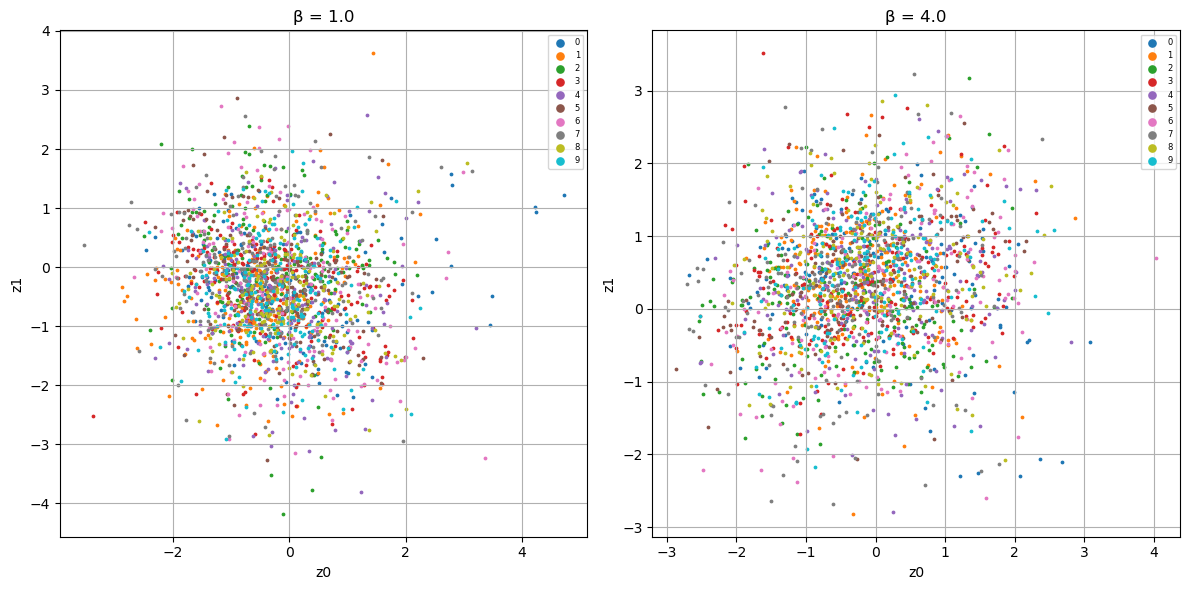

In [20]:
def latent_scatter_side_by_side(models, dataset, betas=[1.0, 4.0], n=2000):
    import matplotlib.pyplot as plt
    import numpy as np
    from torch.utils.data import DataLoader
    
    plt.figure(figsize=(12,6))
    
    for i, beta in enumerate(betas):
        model = models[beta]['model']
        model.eval()
        zs = []
        ys = []
        with torch.no_grad():
            loader = DataLoader(dataset, batch_size=256, shuffle=False)
            for x, y in loader:
                x = x.to(device)
                y = y.to(device)
                _, mu, _, _ = model(x, y)
                zs.append(mu.cpu().numpy())
                ys.append(y.cpu().numpy())
                if sum(map(len, zs)) >= n:
                    break
        zs = np.concatenate(zs, axis=0)[:n]
        ys = np.concatenate(ys, axis=0)[:n]
        
        ax = plt.subplot(1, len(betas), i+1)
        for digit in range(10):
            mask = ys == digit
            ax.scatter(zs[mask,0], zs[mask,1], s=3, label=str(digit))
        ax.set_title(f"β = {beta}")
        ax.set_xlabel("z0")
        ax.set_ylabel("z1")
        ax.legend(markerscale=3, fontsize=6)
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Call the function for β=1 and β=4
latent_scatter_side_by_side(results, test_ds, betas=[1.0, 4.0], n=2000)


Observation on Latent Space Clusters (β = 1 vs β = 4):

For β = 1, the latent space displays clusters for each digit that are reasonably compact, clearly defined, and have little overlap. This suggests that both local structure and reconstruction quality are maintained by the model. Because the KL-divergence penalty is higher for β = 4, the clusters become more dispersed and isolated, indicating stronger disentanglement. A trade-off between cluster compactness and latent space disentanglement is evident in the slight overlap between some similar digits (such as 4 and 9) as global separation improves. In general, cluster tightness decreases as β increases, but separation is improved overall.

# Part 4: Latent Traversals & Manifold

In [69]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def latent_traversals_with_gap(model, digits=range(10), z_range=(-3,3), steps=9, gap=2, device='cuda'):
    
    model.eval()
    total_cols = steps * 2 + gap
    fig, axes = plt.subplots(len(digits), total_cols, figsize=(total_cols*1.2, len(digits)*1.5))
    
    for row, digit in enumerate(digits):
        labels = torch.full((steps,), digit, dtype=torch.long).to(device)
        
        # z0 traversal (fix z1=0)
        z1_fixed = 0.0
        z0_vals = np.linspace(z_range[0], z_range[1], steps)
        zs_z0 = torch.tensor(np.stack([z0_vals, [z1_fixed]*steps], axis=1), dtype=torch.float32).to(device)
        with torch.no_grad():
            imgs_z0 = torch.sigmoid(model.decode(zs_z0, labels)).cpu()
        
        # z1 traversal (fix z0=0)
        z0_fixed = 0.0
        z1_vals = np.linspace(z_range[0], z_range[1], steps)
        zs_z1 = torch.tensor(np.stack([[z0_fixed]*steps, z1_vals], axis=1), dtype=torch.float32).to(device)
        with torch.no_grad():
            imgs_z1 = torch.sigmoid(model.decode(zs_z1, labels)).cpu()
        
        # Plot z0 traversal (left)
        for col in range(steps):
            axes[row, col].imshow(imgs_z0[col][0], cmap='gray')
            axes[row, col].axis('off')
            if col == 0:
                axes[row, col].set_ylabel(f"{digit}", fontsize=12)
        
        # Leave gap
        for g in range(gap):
            axes[row, steps + g].axis('off')
        
        # Plot z1 traversal (right)
        for col in range(steps):
            axes[row, steps + gap + col].imshow(imgs_z1[col][0], cmap='gray')
            axes[row, steps + gap + col].axis('off')
                                            
    fig.text(0.05, 0.95, 'z0 traversal', fontsize=18 )
    fig.text(0.55, 0.95, 'z1 traversal', fontsize=18 )
    
    plt.tight_layout(rect=[0,0,1,0.93])  
    plt.show()

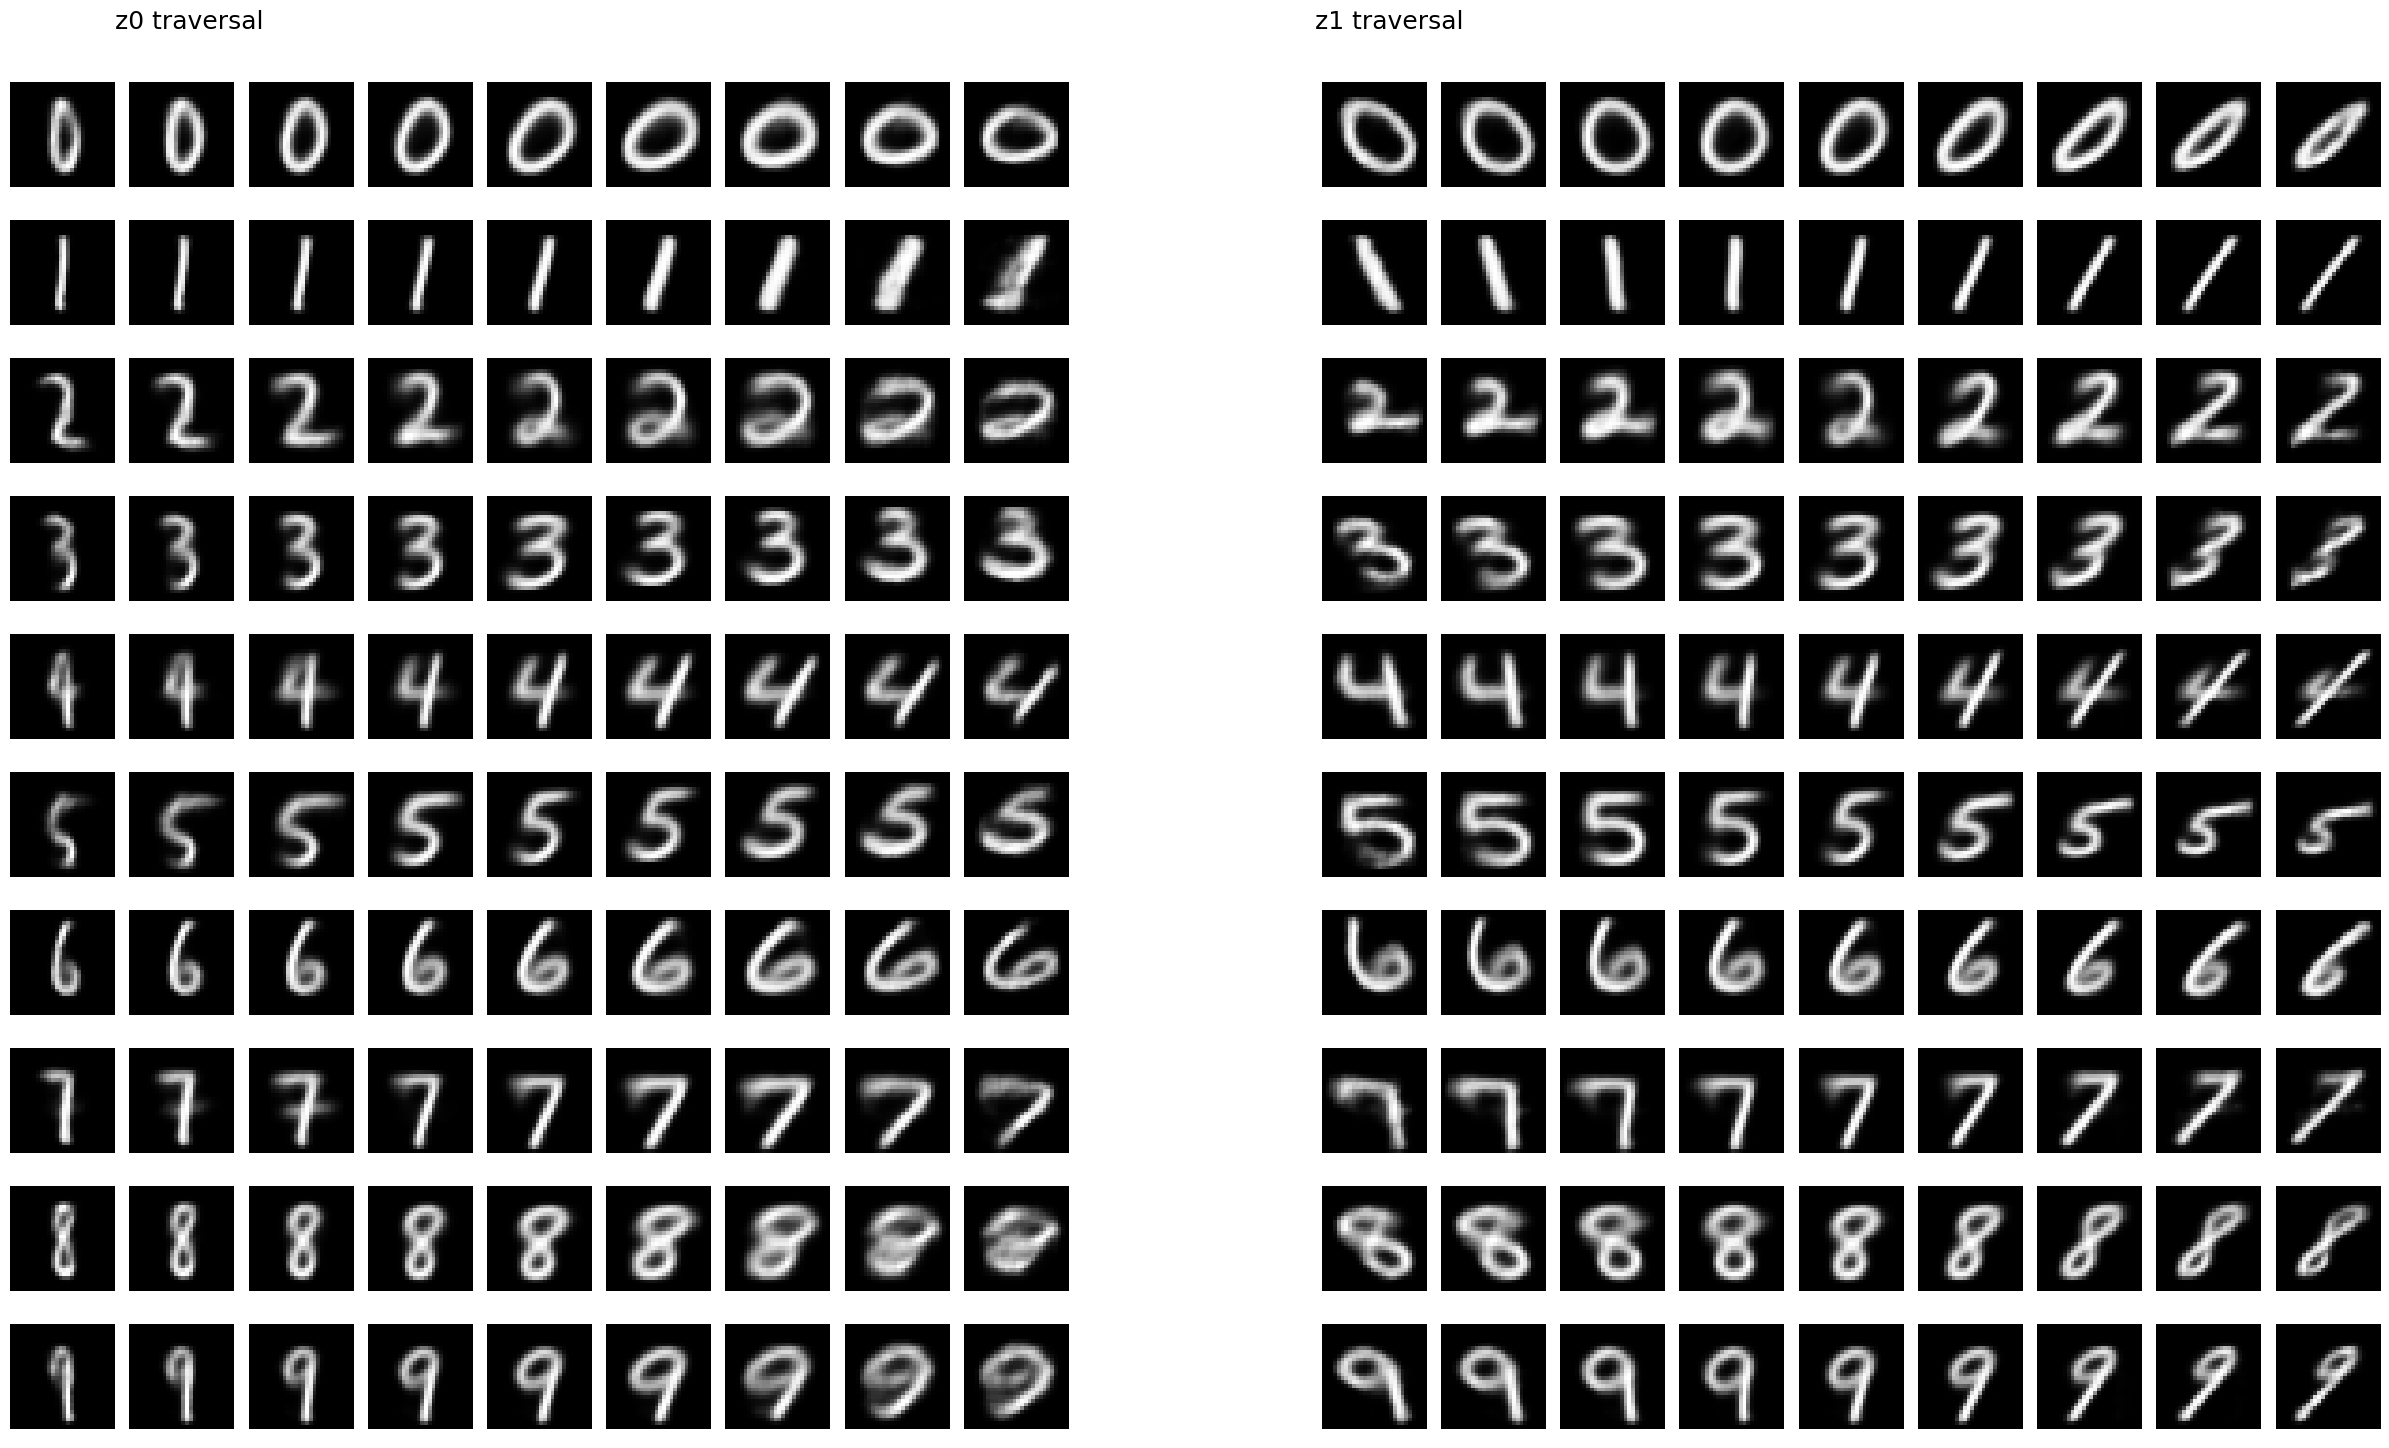

In [70]:
# for Beta = 0
latent_traversals_with_gap(results[1.0]['model'], device=device)


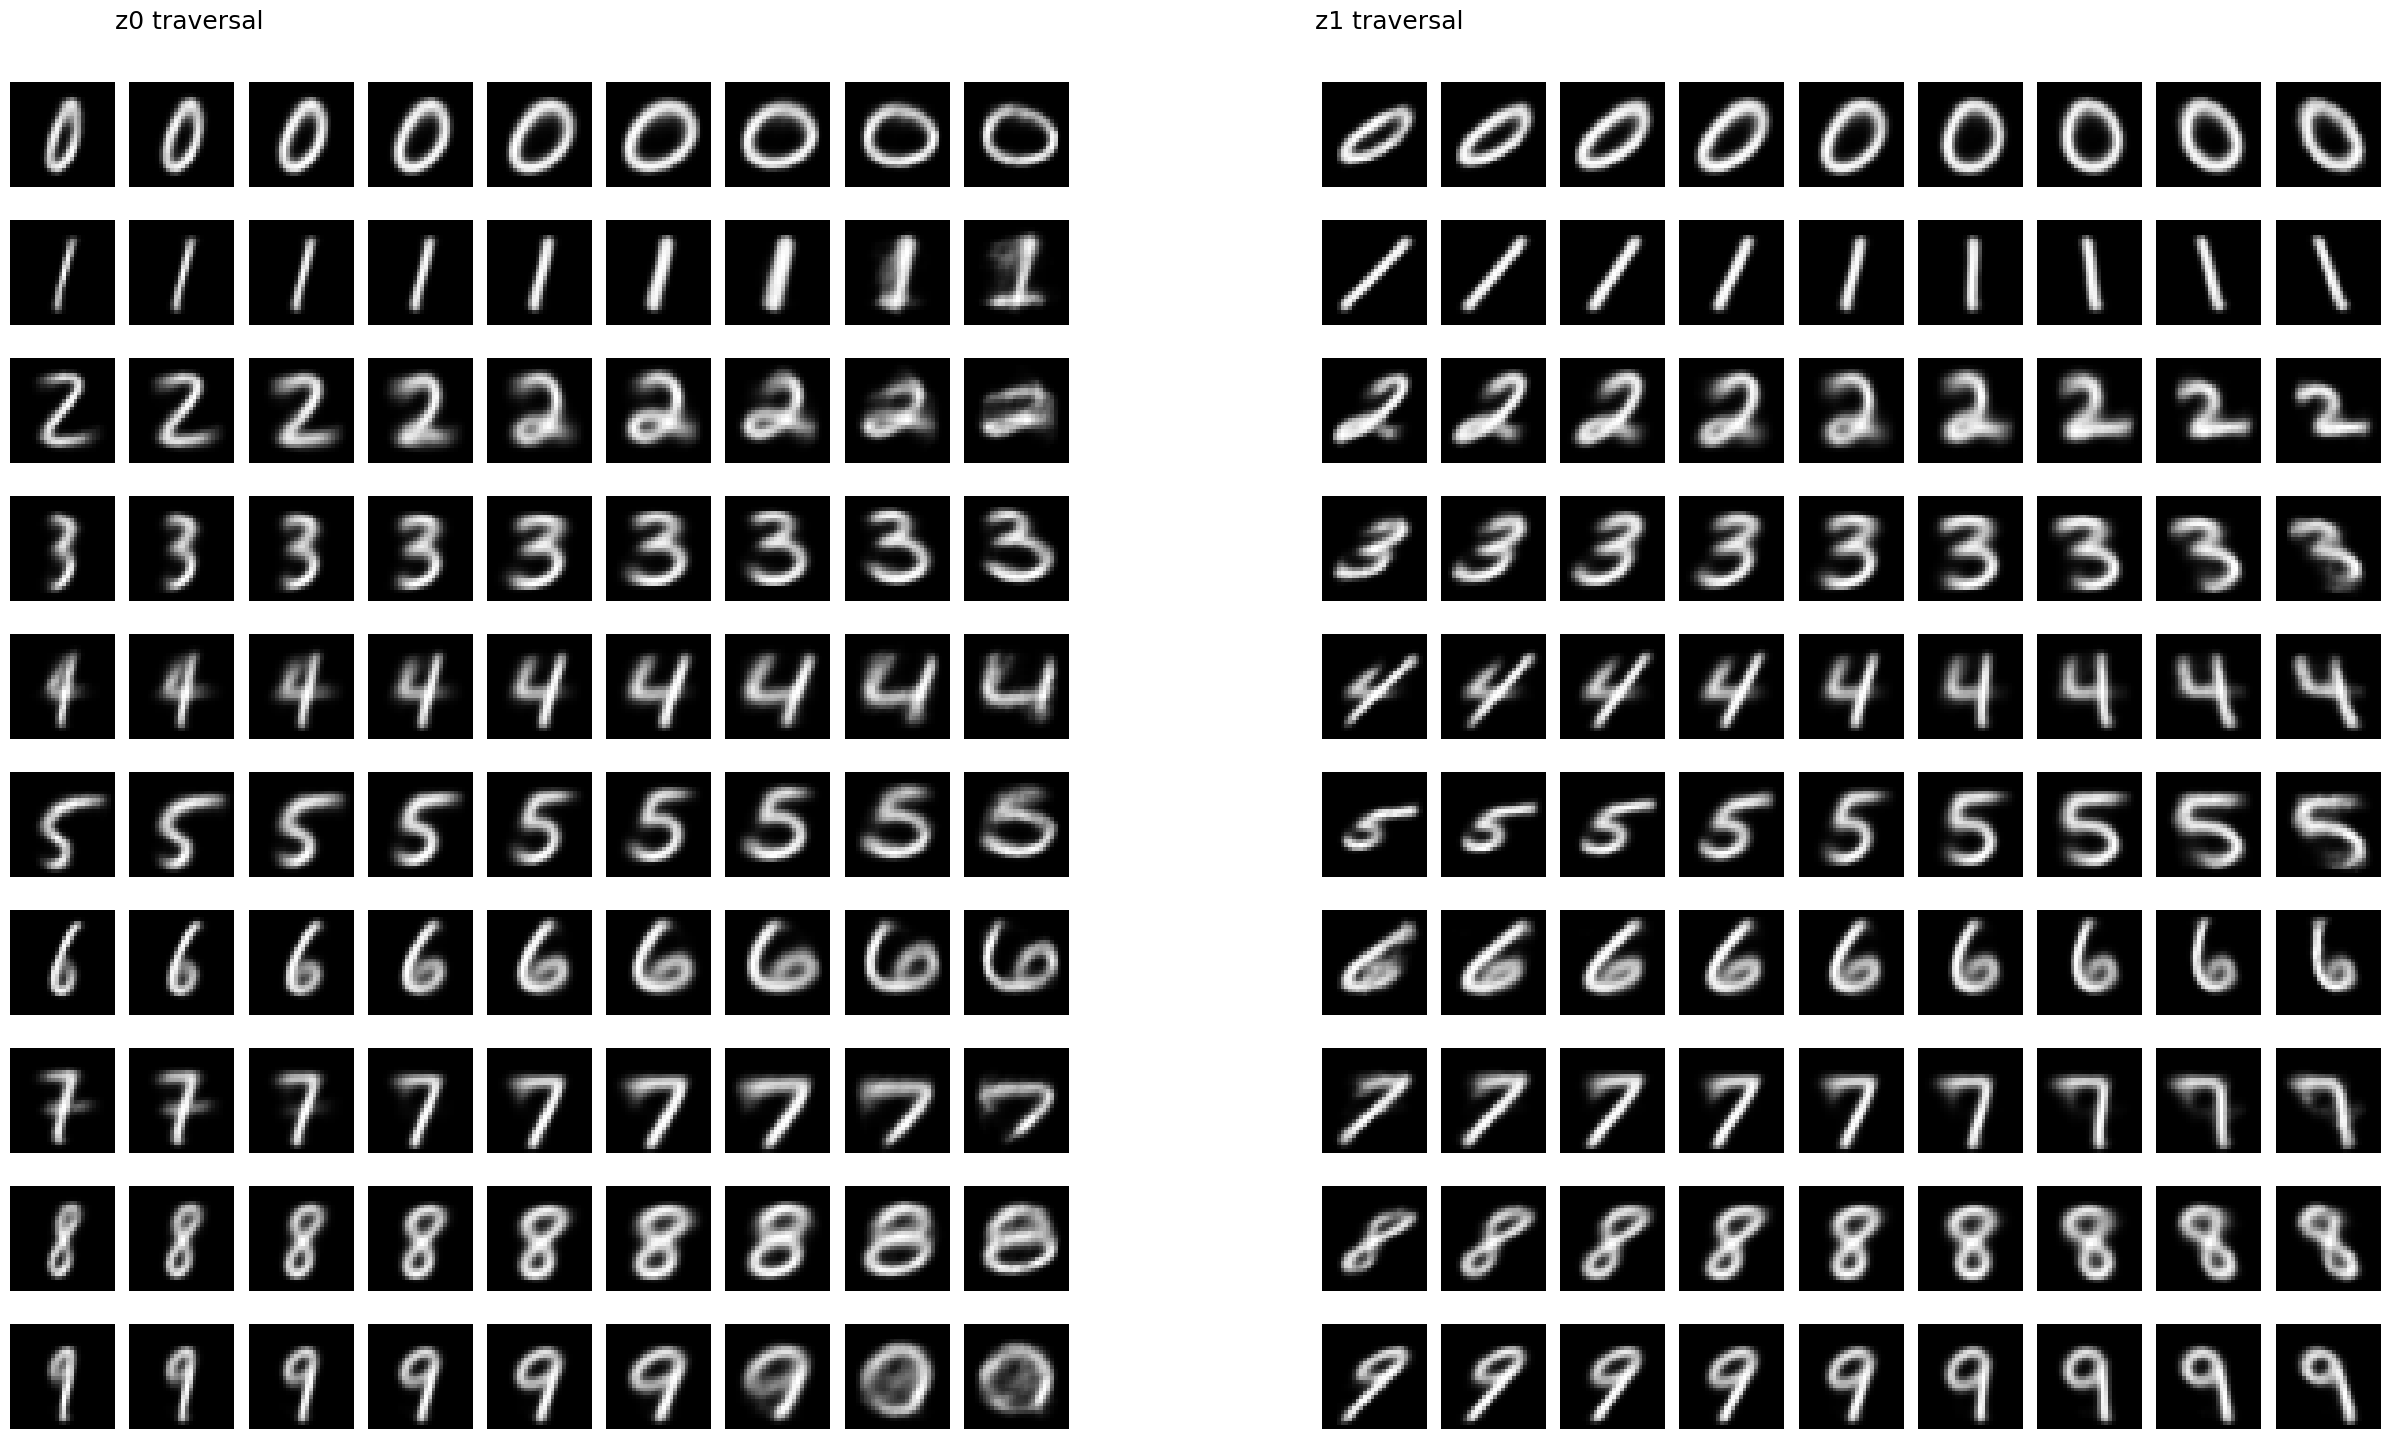

In [71]:
# for Beta = 4
latent_traversals_with_gap(results[4.0]['model'], device=device)


In [57]:
def latent_manifold_beta(model, digit, beta, grid_size=18, zmin=-3, zmax=3, device='cuda'):
    model.eval()
    
    # Create grid of latent vectors
    lin = np.linspace(zmin, zmax, grid_size)
    mesh = np.stack(np.meshgrid(lin, lin), -1).reshape(-1, 2)  # (grid_size^2, 2)
    
    # Labels
    labels = torch.full((mesh.shape[0],), digit, dtype=torch.long).to(device)
    
    # Convert mesh to tensor
    zs = torch.tensor(mesh, dtype=torch.float32).to(device)
    
    # Decode
    with torch.no_grad():
        logits = model.decode(zs, labels)
        imgs = torch.sigmoid(logits).cpu()
    
    # Show grid with beta in title
    show_image_grid(imgs, nrow=grid_size, title=f"Manifold for digit {digit}, β={beta}")

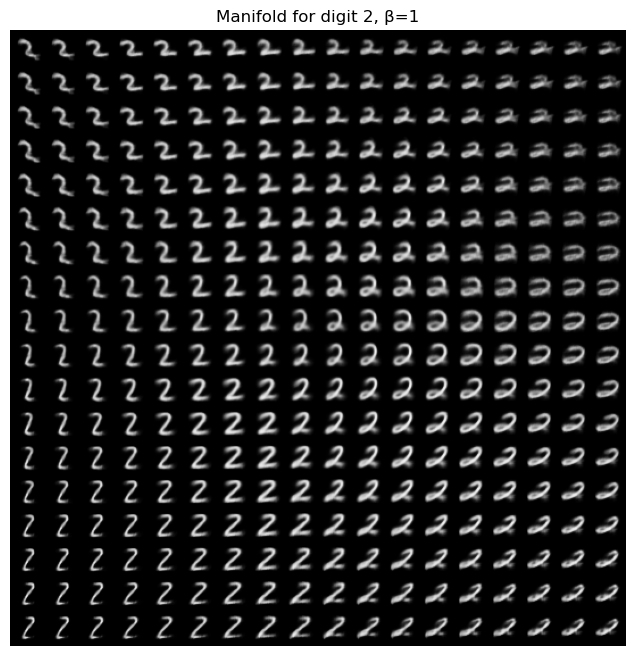

In [58]:
latent_manifold_beta(results[1.0]['model'], digit=2, beta=1, grid_size=18, device=device)

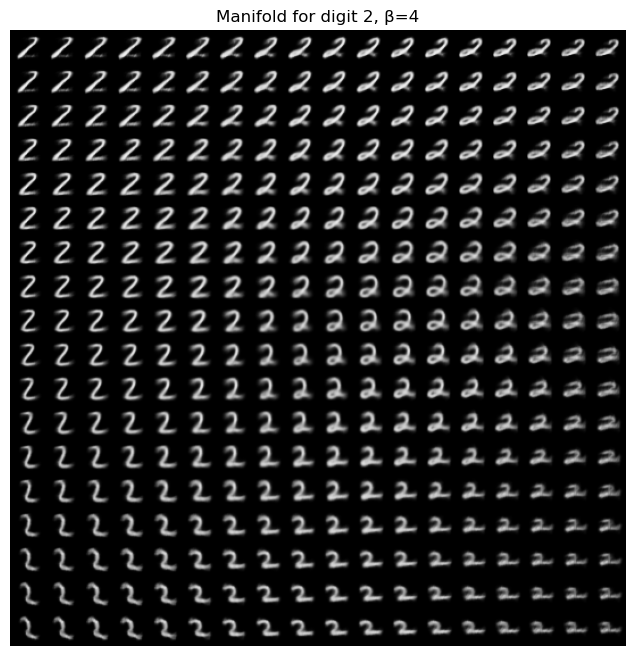

In [59]:
latent_manifold_beta(results[4.0]['model'], digit=2, beta=4, grid_size=18, device=device)